# Fixing the Vanishing Gradient Problem with Rectified Linear Unit (ReLU)

## Example Problem: Two Circles Binary Classification

To help investigate the problem, we study the classic binary classification problem. We use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function provided by `scikit-learn` to create a binary classification problem with given number of samples and statistical noise.

In [1]:
# import required libraries
from sklearn.datasets import make_circles
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from skorch import NeuralNetBinaryClassifier

We create the dataset with $X$ denoting the input variables (coordinates in the Cartesian plane) and the label vector $y$ denoting class values in $\{0, 1\}$. The points are arranged in two concentric circles for the two classes, with parameters:
- `n_samples`: number of points in the dataset, where half of the data points will be drawn for each circle
- `noise`: the standard deviation of the noise, `noise = 0.0` indicates no noise or points drawn exactly from the circles
- `random_state`: seed for the pseudorandom number generator for reproducibility

The statistical noise causes the overlap of the points in the two classes.

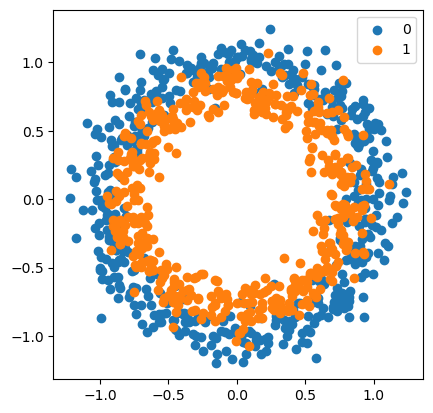

In [2]:
# generate circles
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

for i in range(len(np.unique(y))):
    sample_indices = np.where(y == i)
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], label=str(i))
plt.legend()
plt.axis('square');

## Multi-Layer Perceptron

In [3]:
# select device based on hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# scale the data into [-1., 1.]
scaler = MinMaxScaler(feature_range=(-1., 1.))
X = scaler.fit_transform(X)

In [5]:
X, y = X.astype(np.float32), y.astype(np.float32)

In [6]:
# train/test split
num_train = int(0.8 * len(y))
trainX, testX = X[:num_train, :], X[num_train:, :]
trainy, testy = y[:num_train], y[num_train:]

In [7]:
# weight initializer function
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.uniform_(module.weight, 0., 1.)

In [8]:
# some common hyperparameters
max_epochs = 500
lr = 0.01
verbose = 1

In [9]:
class MultiLayerPerceptronTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1),
        )

    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [10]:
net_tanh = NeuralNetBinaryClassifier(
    MultiLayerPerceptronTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [11]:
history_tanh = net_tanh.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7102       0.5000        0.7129  0.7826
      2        0.7095       0.5000        0.7123  0.0093
      3        0.7089       0.5000        0.7116  0.0096
      4        0.7083       0.5000        0.7110  0.0092
      5        0.7077       0.5000        0.7104  0.0103
      6        0.7072       0.5000        0.7099  0.0102
      7        0.7066       0.5000        0.7093  0.0101
      8        0.7061       0.5000        0.7088  0.0098
      9        0.7056       0.5000        0.7083  0.0093
     10        0.7052       0.5000        0.7078  0.0108
     11        0.7047       0.5000        0.7074  0.0113
     12        0.7043       0.5000        0.7069  0.0102
     13        0.7039       0.5000        0.7065  0.0104
     14        0.7035       0.4938        0.7061  0.0100
     15        0.7031       0.4938        0.7057  0.0091
     16        0.7027       0.5

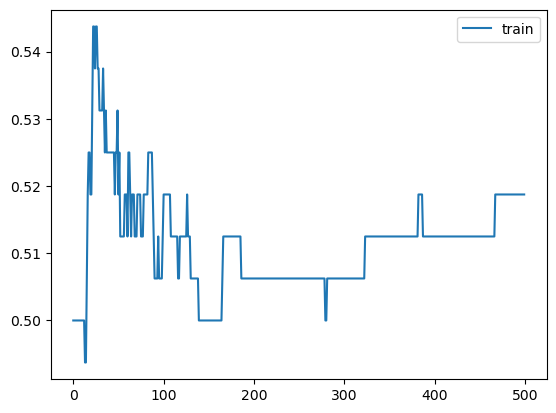

In [12]:
plt.plot(history_tanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [13]:
# evaluate the model
predictions_tanh = net_tanh.predict(testX)
test_acc_tanh = np.sum(predictions_tanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_tanh}')

Average test accuracy: 0.515


In [14]:
del history_tanh

In [15]:
class MultiLayerPerceptronReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [16]:
net_relu = NeuralNetBinaryClassifier(
    MultiLayerPerceptronReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [ ]:
history_relu = net_relu.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7150       0.5000        0.7164  0.0134
      2        0.7143       0.5000        0.7156  0.0140
      3        0.7136       0.5000        0.7149  0.0143
      4        0.7129       0.5000        0.7142  0.0154
      5        0.7122       0.5000        0.7134  0.0182
      6        0.7116       0.5000        0.7128  0.0144
      7        0.7109       0.5000        0.7121  0.0121
      8        0.7103       0.5000        0.7115  0.0166
      9        0.7098       0.5000        0.7109  0.0153
     10        0.7092       0.5000        0.7103  0.0199
     11        0.7086       0.5000        0.7097  0.0142
     12        0.7081       0.5000        0.7091  0.0137
     13        0.7076       0.5000        0.7086  0.0127
     14        0.7071       0.5000        0.7080  0.0106
     15        0.7066       0.5000        0.7075  0.0133
     16        0.7062       0.5

In [ ]:
plt.plot(history_relu.history[:, 'train_loss'], label='train')
plt.plot(history_relu.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_relu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
predictions_relu = net_relu.predict(testX)
test_acc_relu = np.sum(predictions_relu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_relu}')

## Deeper Models

In [ ]:
layer = torch.nn.Linear(in_features=5, out_features=5)

In [ ]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [ ]:
deepnet_tanh = NeuralNetBinaryClassifier(
    DeepNeuralNetworkTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [ ]:
history_deeptanh = deepnet_tanh.fit(trainX, trainy)

In [ ]:
plt.plot(history_deeptanh.history[:, 'train_loss'], label='train')
plt.plot(history_deeptanh.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_deeptanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
predictions_deeptanh = deepnet_tanh.predict(testX)
test_acc_deeptanh = np.sum(predictions_deeptanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeptanh}')

In [ ]:
del history_deeptanh

In [ ]:
del deepnet_tanh

In [ ]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [ ]:
deepnet_relu = NeuralNetBinaryClassifier(
    DeepNeuralNetworkReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [ ]:
history_deeprelu = deepnet_relu.fit(trainX, trainy)

In [ ]:
plt.plot(history_deeprelu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [ ]:
# evaluate the model
predictions_deeprelu = deepnet_relu.predict(testX)
test_acc_deeprelu = np.sum(predictions_deeprelu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeprelu}')

In [ ]:
del history_deeprelu

In [ ]:
del deepnet_relu